# Module 4 - Introduction to Neural Networks: Training a Multi-Layer Perceptron


<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/DHI/Intro_ML_course/blob/main/module_4/4_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

In this notebook, we will delve into the fascinating world of neural networks, particularly focusing on training a Multi-Layer Perceptron (MLP) for image classification. Our objective is to utilize the renowned CIFAR-10 dataset, converted to black and white, to introduce you to the fundamentals of building and training neural networks.

### Objectives

1. Implement an architecture using the `Sequential` model in Keras.
2. Compile the model with suitable parameters for efficient training.
3. Utilize various callbacks such as `ReduceLROnPlateau` and `EarlyStopping` to enhance training performance.
4. Study the impact of different batch sizes on the training speed and overall performance of the model.
5. Visualize the results, including model predictions, to gain insights into the learning process and performance metrics.

Throughout this notebook, we will provide step-by-step instructions, code demonstrations, and explanations to help you understand the key concepts and methodologies involved in training neural networks for image classification tasks. By the end of this tutorial, you will have a solid understanding of how to build and train a basic neural network for image classification tasks, along with valuable insights into best practices and performance optimization techniques.

Let's embark on this exciting journey into the realm of neural networks and image classification!

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

# 1. Load the CIFAR-10 Dataset

Before we dive into building and training the Multi-Layer Perceptron (MLP) model, we need to load the CIFAR-10 dataset. CIFAR-10 is a popular image classification dataset that consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. Created by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton, this dataset serves as a benchmark for training and evaluating various image classification models. In this notebook, we will convert the images to grayscale for simplicity.

The dataset is conveniently available through the `tf.keras.datasets.cifar10` module, which allows us to easily load the dataset for training and testing our neural network. The loaded data will be split into training and testing sets, consisting of images and corresponding labels that we will use to train and evaluate our MLP model.

Let's load the CIFAR-10 dataset and get ready to explore the fascinating world of neural networks and image classification!


In [ ]:
# Load the CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

There are 60,000 images of 32 by 32 pixels - 50,000 for training and validation and 10,000 for testing. The images are in color so each pixel is defined by its red, green and blue level.

In [ ]:
train_images.shape

(50000, 32, 32, 3)

The labels are integers between 0 and 9:

In [ ]:
print(train_labels)

[[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]


Let's define the class names corresponding to the CIFAR-10 dataset to establish a relationship between the previous integers and the classes.
- 0: `airplane`
- 1: `automobile`
- 2: `bird`
- 3: `cat`
- 4: `deer`
- 5: `dog`
- 6: `frog`
- 7: `horse`
- 8: `ship`
- 9: `truck`

In [ ]:
# Define the class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

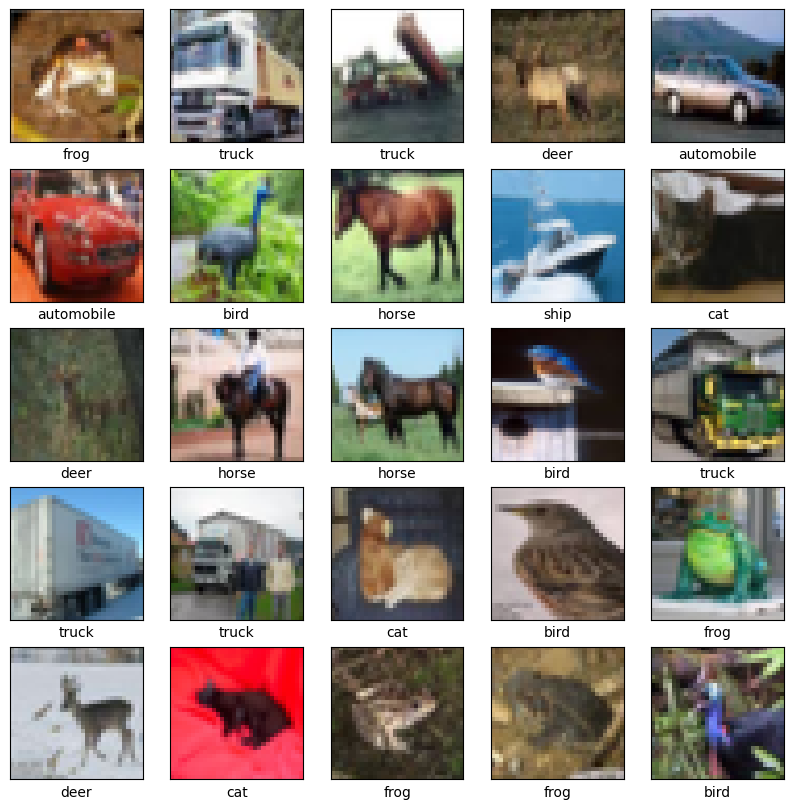

In [ ]:
# Display some sample images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

# 2. Pre-process the data

Before training our neural network, we pre-process the CIFAR-10 images to one-dimensional vector, as we saw in the video:
1.   **Conversion to grayscale**: We average the RGB values to obtain a single intensity
2.   **Flattening**: We transform the $32 \times 32$ pixels images into a one-dimensional vector, where each element represents the intensity value of a single pixel.
3.  **Scaling**: Convert the intensities from integers in the range 0-255 to a `float` value between 0 and 1.

In [ ]:
print(train_images[0, :, :, 0]) # red band of first image

[[ 59  43  50 ... 158 152 148]
 [ 16   0  18 ... 123 119 122]
 [ 25  16  49 ... 118 120 109]
 ...
 [208 201 198 ... 160  56  53]
 [180 173 186 ... 184  97  83]
 [177 168 179 ... 216 151 123]]


In [ ]:
print('Shape of dataset before pre-processing', train_images.shape)

# Convert to grayscale
train_data = train_images.mean(axis=-1)
test_data = test_images.mean(axis=-1)
print('Shape of dataset after grayscale', train_data.shape)

# Flatten images - convert to a 1d vector
train_data = train_data.reshape((50000, 32*32))
test_data = test_data.reshape((10000, 32*32))
print('Shape of dataset after flattening', train_data.shape)

# Scaling - from 0-255 to 0-1
train_data = train_data/255.
test_data = test_data/255.

Shape of dataset before pre-processing (50000, 32, 32, 3)
Shape of dataset after grayscale (50000, 32, 32)
Shape of dataset after flattening (50000, 1024)


In [ ]:
print(train_data[0]) # 1d vector corresponding to first image

[0.24052288 0.1751634  0.18431373 ... 0.70588235 0.46143791 0.3751634 ]


Flattened, the images look like this:

Text(0.5, 1.0, 'This is a frog')

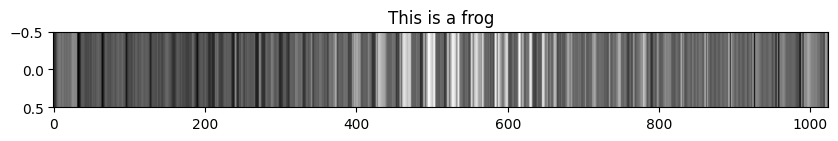

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.imshow(train_data[0].reshape(1, -1), cmap='gray')
ax.set_aspect(100)
ax.set_title('This is a ' + class_names[train_labels[0][0]])

# 3. Build a multi-layer perceptron (MLP)


We construct a Multi-Layer Perceptron (MLP) model using the Keras `Sequential` API. The model architecture consists of the following layers:

1. **Input Layer:** The input shape is explicitly defined to accept the flattened black and white images.

2. **Dense Layers:** We incorporate two hidden dense layers with 128 and 64 neurons, respectively, using `ReLU` (Rectified Linear Unit) activation functions. These layers enable the network to learn complex patterns and representations from the flattened input data.

3. **Output Layer:** The final dense layer consists of 10 neurons, representing the probabilties of each of the 10 classes in the CIFAR-10 dataset. The `SoftMax` activation function converts raw values to probabilties (values between 0 and 1 which sum is equal to 1).

By constructing this MLP model, we aim to leverage its capacity to learn and classify the pre-processed image data accurately. Let's proceed with compiling the model and configuring the necessary parameters for training.


In [ ]:
model = keras.Sequential([
    layers.Input(shape=(1024,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               131200    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 140106 (547.29 KB)
Trainable params: 140106 (547.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



After constructing the layers of our Multi-Layer Perceptron (MLP) model, we need to compile it to configure the learning process. The `compile` method allows us to define the optimizer, loss function, and evaluation metrics for training the model. In this case, we set the following configurations:

1. **Optimizer:** We utilize the widely-used `Adam` optimizer which is gradient descent method.

2. **Learning Rate:** The learning rate parameter controls the step size during optimization and influences the speed and quality of convergence during training.

3. **Loss Function:** For the multi-class classification task, we employ the `SparseCategoricalCrossentropy` loss function, which is well-suited for scenarios where the target labels are provided as integers.

4. **Metrics:** We track the 'accuracy' metric during training to monitor the performance of the model and assess its classification accuracy.

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# 4. Train the model


To train the Multi-Layer Perceptron (MLP) model on the pre-processed CIFAR-10 dataset, we utilize the magical function `model.fit` function. We need to provide the following:

1. **Training Data:** The pre-processed training data is provided to the model for learning patterns and features associated with the input images.

2. **Training Labels:** The corresponding labels for the training data are provided to guide the model during the learning process.

3. **Batch Size:** We set the batch size to 128, determining the number of samples used in each iteration for updating the model's weights.

4. **Epochs:** The model is trained for 10 epochs, representing the number of times the entire dataset is passed forward and backward through the neural network.

5. **Validation Data:** We evaluate the model's performance on the provided test dataset (`test_data` and `test_labels`) to monitor its generalization ability during training.


In [ ]:
history = model.fit(train_data, train_labels, batch_size=64, epochs=10, validation_data=(test_data, test_labels))

Epoch 1/10
782/782 [==============================] - 10s 11ms/step - loss: 2.1121 - accuracy: 0.2326 - val_loss: 2.0282 - val_accuracy: 0.2744
Epoch 2/10
782/782 [==============================] - 10s 13ms/step - loss: 1.9870 - accuracy: 0.2917 - val_loss: 1.9644 - val_accuracy: 0.3054
Epoch 3/10
782/782 [==============================] - 12s 15ms/step - loss: 1.9288 - accuracy: 0.3181 - val_loss: 1.9021 - val_accuracy: 0.3321
Epoch 4/10
782/782 [==============================] - 8s 10ms/step - loss: 1.8863 - accuracy: 0.3343 - val_loss: 1.8736 - val_accuracy: 0.3470
Epoch 5/10
782/782 [==============================] - 10s 13ms/step - loss: 1.8500 - accuracy: 0.3465 - val_loss: 1.8432 - val_accuracy: 0.3536
Epoch 6/10
782/782 [==============================] - 5s 7ms/step - loss: 1.8201 - accuracy: 0.3601 - val_loss: 1.8326 - val_accuracy: 0.3578
Epoch 7/10
782/782 [==============================] - 6s 8ms/step - loss: 1.7942 - accuracy: 0.3686 - val_loss: 1.7987 - val_accuracy: 0.36

Text(0.5, 1.0, 'Learning curves')

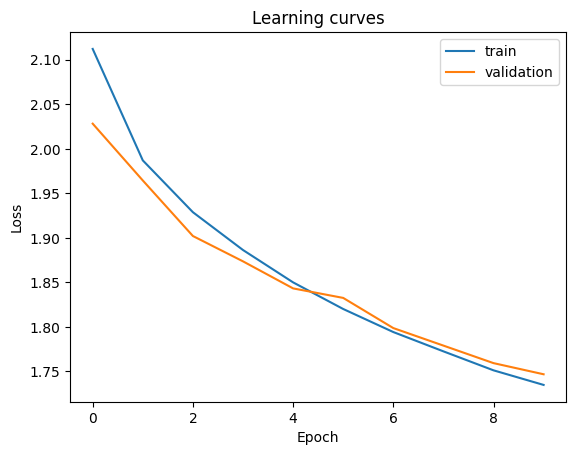

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Learning curves')

It appears that the model is in the process of learning, but after 10 epochs, it's possible that the model has not fully converged. To ensure that the model has sufficient time to learn the underlying patterns in the data, we will continue the learning but, this time, with an *early stopping callback*.
This technique allows us to continue training the model until the validation loss stabilizes, indicating that the model has reached an optimal point of convergence. By incorporating the early stopping mechanism, we can prevent overfitting and ensure that the model generalizes well to unseen data.

In [ ]:
# Defining the early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the model with the early stopping callback
history = model.fit(train_data, train_labels,
                    batch_size=128,
                    epochs=100,
                    validation_data=(test_data, test_labels),
                    callbacks=[early_stopping])

Epoch 1/100
391/391 [==============================] - 3s 7ms/step - loss: 1.7078 - accuracy: 0.4028 - val_loss: 1.7332 - val_accuracy: 0.3851
Epoch 2/100
391/391 [==============================] - 3s 8ms/step - loss: 1.7009 - accuracy: 0.4075 - val_loss: 1.7295 - val_accuracy: 0.3922
Epoch 3/100
391/391 [==============================] - 4s 10ms/step - loss: 1.6919 - accuracy: 0.4089 - val_loss: 1.7188 - val_accuracy: 0.3941
Epoch 4/100
391/391 [==============================] - 3s 7ms/step - loss: 1.6822 - accuracy: 0.4131 - val_loss: 1.7236 - val_accuracy: 0.3896
Epoch 5/100
391/391 [==============================] - 3s 7ms/step - loss: 1.6724 - accuracy: 0.4163 - val_loss: 1.7143 - val_accuracy: 0.3905
Epoch 6/100
391/391 [==============================] - 3s 7ms/step - loss: 1.6642 - accuracy: 0.4184 - val_loss: 1.7033 - val_accuracy: 0.3962
Epoch 7/100
391/391 [==============================] - 3s 8ms/step - loss: 1.6559 - accuracy: 0.4204 - val_loss: 1.6882 - val_accuracy: 0.407

**Note**: Here, `patience=3` implies that training will stop after 3 epochs with no improvement in the validation loss. Setting `restore_best_weights=True` ensures that the model's weights are restored to the best achieved state, as determined by the minimum loss on the test data, at the end of training.

Text(0.5, 1.0, 'Learning curves - part 2')

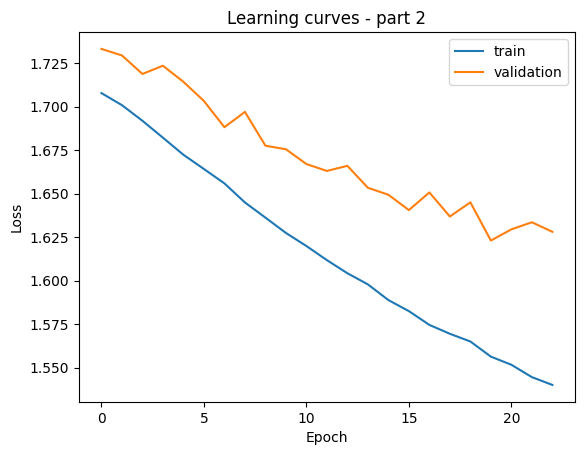

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Learning curves - part 2')

We might want to increase the patience, it seems like the model did not converge yet...

**Reminder**: https://playground.tensorflow.org/ is a great resource to get an understanding of neural networks

# 5. Evaluate the model

We will evaluate the performance of our trained Multi-Layer Perceptron (MLP) model for image classification on the test dataset.

First, let's output the probabilities (one for each of the ten classes) of the 10,000 test images:




In [ ]:
predictions = model.predict(test_data)
predictions.shape

313/313 [==============================] - 1s 2ms/step


(10000, 10)

**Run the following block multiple times to check the results on various images**

<ipython-input-32-1c395c1a2225>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(class_names, rotation=45, ha='right')


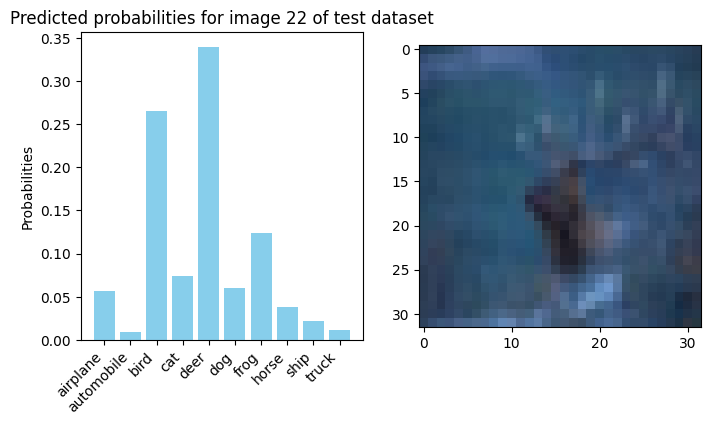

In [ ]:
# pick one instance in the test dataset
random_index = np.random.randint(len(test_data))

# display probabilities
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].bar(class_names, predictions[random_index], color='skyblue')
ax[0].set_title(f'Predicted probabilities for image {random_index} of test dataset')
ax[0].set_ylabel('Probabilities')
ax[0].set_xticklabels(class_names, rotation=45, ha='right')

# show image
ax[1].imshow(test_images[random_index])

We assign each instance to the class with maximal probability:

In [ ]:
# from probabilities to predict
predicted_classes = np.argmax(predictions, axis=-1)
predicted_classes.shape

(10000,)

The confusion matrix helps us identify pairs like 'dog' and 'cat,' 'automobile' and 'truck,' and 'airplane' and 'ship,' which the model might have difficulties telling apart due to their visual similarities.

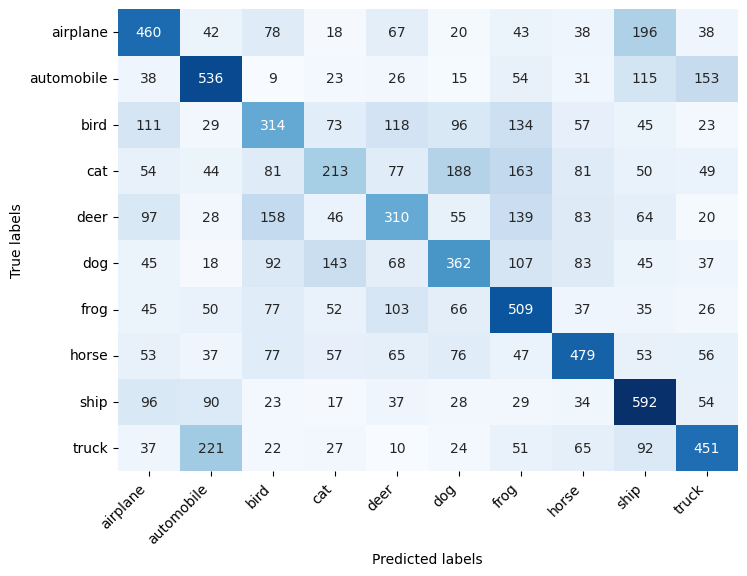

In [ ]:
# display confusion matrix
cm = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
# Exercise - derive the accuracy score on the test dataset
print('Accuracy score:', accuracy_score(test_labels, predicted_classes))

Accuracy score: 0.4226


# 6. Learning rate


Understanding the impact of the learning rate on the training process is crucial for optimizing model performance. In this module, we'll see how the learning rate influences the speed of model convergence and the overall efficiency of the training process. By exploring the relationship between the learning rate and loss function, we'll try to identify the optimal learning rate for our Multi-Layer Perceptron (MLP) model on the CIFAR-10 dataset.

In [ ]:
# function which defines, compiles and trains a model for values of lr and batch size
def train_model_with_learning_rate(learning_rate, batch_size):
    model = keras.Sequential([layers.Input(shape=(1024,)),
                              layers.Dense(128, activation='relu'),
                              layers.Dense(64, activation='relu'),
                              layers.Dense(10, activation='softmax')])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    history = model.fit(train_data, train_labels, batch_size=batch_size, epochs=10,
                        validation_data=(test_data, test_labels))
    return history

By looping over the different learning rate, we can compare their learning curves.

**Note**: running the following block can be quite long (a few minutes)...

In [ ]:
histories = []
for lr in [0.00001, 0.0001, 0.001, 0.01, 0.1]:
  print(f'-------------- Learning rate = {lr} --------------')
  history = train_model_with_learning_rate(learning_rate=lr, batch_size=128)
  histories.append(history)

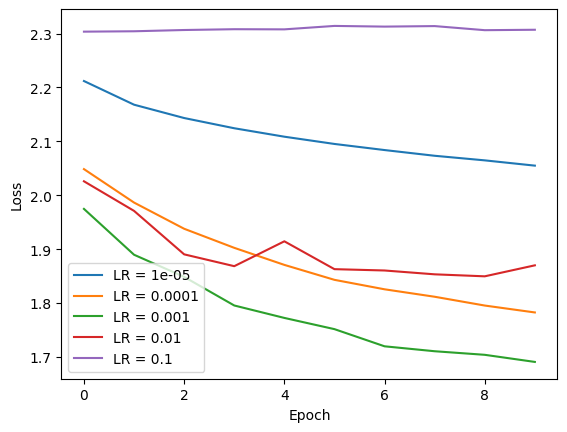

In [ ]:
# display the learning curves (validation loss)
for i, lr in enumerate([0.00001, 0.0001, 0.001, 0.01, 0.1]):
  plt.plot(histories[i].history['val_loss'], label='LR = ' + str(lr))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()


# 7. Exercise - Influence of the batch size on the training speed

**Exercise**: By training the model with various values of batch size (for instance: 4, 16, 32, 256, 1024), find out how this hyperparameter influences the learning curves.

**Note**: Training a model on multiple epochs with a low number of batch size (e.g. 4) can be very slow due to the increased frequency of weight updates. Increasing the batch size allows for more efficient parallel processing, and a too high batch size might lead to a memory overload.

In [ ]:
histories = []
for batch_size in [4, 16, 64, 256, 1024]:
  print(f'-------------- Batch size = {batch_size} --------------')
  history = train_model_with_learning_rate(learning_rate=0.001, batch_size=batch_size)
  histories.append(history)

-------------- Batch size = 4 --------------
Epoch 1/10
12500/12500 [==============================] - 66s 5ms/step - loss: 2.0306 - accuracy: 0.2634 - val_loss: 1.9144 - val_accuracy: 0.3148
Epoch 2/10
12500/12500 [==============================] - 57s 5ms/step - loss: 1.9166 - accuracy: 0.3104 - val_loss: 1.8887 - val_accuracy: 0.3267
Epoch 3/10
12500/12500 [==============================] - 66s 5ms/step - loss: 1.8855 - accuracy: 0.3227 - val_loss: 1.8569 - val_accuracy: 0.3402
Epoch 4/10
12500/12500 [==============================] - 59s 5ms/step - loss: 1.8638 - accuracy: 0.3340 - val_loss: 1.8873 - val_accuracy: 0.3273
Epoch 5/10
12500/12500 [==============================] - 57s 5ms/step - loss: 1.8495 - accuracy: 0.3333 - val_loss: 1.8284 - val_accuracy: 0.3515
Epoch 6/10
12500/12500 [==============================] - 57s 5ms/step - loss: 1.8391 - accuracy: 0.3407 - val_loss: 1.8766 - val_accuracy: 0.3263
Epoch 7/10
12500/12500 [==============================] - 59s 5ms/step - 

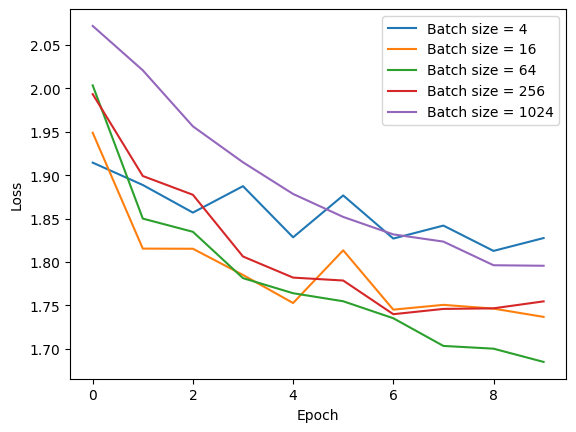

In [ ]:
for i, bacth_size in enumerate([4, 16, 64, 256, 1024]):
  plt.plot(histories[i].history['val_loss'], label='Batch size = ' + str(bacth_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# 8. Exercise - do colors matter?

**Exercise**: Train a model which uses the original color images instead of the grayscale images. Does this model outperform the previous model - i.e. do colors help the model to interpret images?

**Hint**: You can consider converting each image - of original shape $(32, 32, 3)$ - to a one-dimensional vector of shape $(3072, )$

In [ ]:
print('Shape of dataset before pre-processing', train_images.shape)

# Flatten images - convert to a 1d vector
train_data = train_images.reshape((50000, 32*32*3))
test_data = test_images.reshape((10000, 32*32*3))
print('Shape of dataset after flattening', train_data.shape)

# Scaling - from 0-255 to 0-1
train_data = train_data/255.
test_data = test_data/255.

Shape of dataset before pre-processing (50000, 32, 32, 3)
Shape of dataset after flattening (50000, 3072)


In [ ]:
# Define a model architecture
model = keras.Sequential([
    layers.Input(shape=(3072,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [ ]:
# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(train_data, train_labels,
                    batch_size=128,
                    epochs=20,
                    validation_data=(test_data, test_labels))

In [ ]:
# Predict classes
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=-1)

313/313 [==============================] - 1s 3ms/step


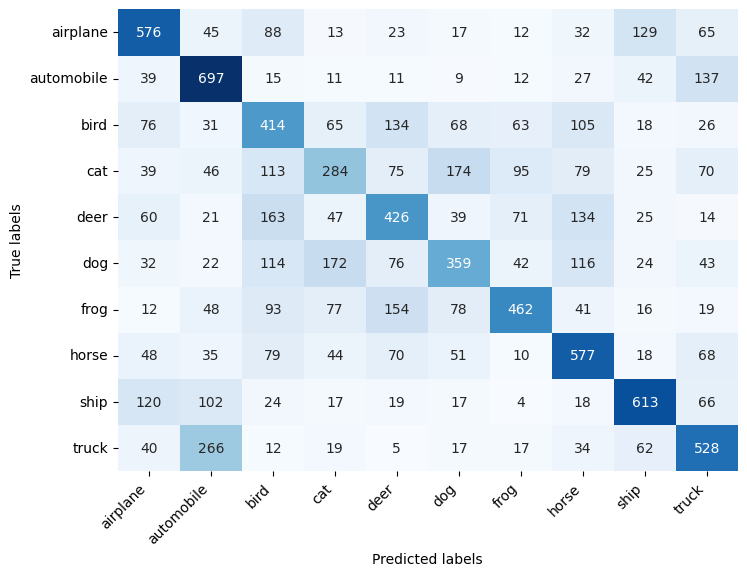

In [ ]:
# Confusion matrix
cm = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
# Accuracy score on the test dataset?
print('Accuracy score:', accuracy_score(test_labels, predicted_classes))

Accuracy score: 0.4936


From around 42% accuracy to around 49% accuracy, colors seem to matter!

# 9. Optional content - Keras callback: Reduce learning rate on plateau

Keras offers powerful callbacks to monitor and adjust the model during training. We'll focus on two key callbacks:

- **ReduceLROnPlateau:** Adjusts the learning rate during plateaus for stable convergence. It uses high learning rate at the start of the training and gradually reduces it.
- **EarlyStopping:** Halts training when validation loss stagnates, preventing overfitting. We already used it in section 4.

Implementing these callbacks enhances our MLP model's learning and performance on the CIFAR-10 dataset.

In [ ]:
# Defining the ReduceLROnPlateau callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.5, patience=4, min_lr=0.000001)

# Defining the EarlyStopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=7, restore_best_weights=True)

Re-initialize and compile the model, this time with a larger learning rate (0.01 instead of 0.001)

In [ ]:
model = keras.Sequential([layers.Input(shape=(3072,)),
                              layers.Dense(128, activation='relu'),
                              layers.Dense(64, activation='relu'),
                              layers.Dense(10, activation='softmax')])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# Adding the callbacks to the model training
history = model.fit(train_data, train_labels,
                    batch_size=128,
                    epochs=100,
                    validation_data=(test_data, test_labels),
                    callbacks=[reduce_lr, early_stop])

Epoch 1/100
391/391 [==============================] - 8s 14ms/step - loss: 1.9069 - accuracy: 0.3118 - val_loss: 1.7858 - val_accuracy: 0.3659 - lr: 0.0010
Epoch 2/100
391/391 [==============================] - 6s 16ms/step - loss: 1.7184 - accuracy: 0.3865 - val_loss: 1.6479 - val_accuracy: 0.4170 - lr: 0.0010
Epoch 3/100
391/391 [==============================] - 5s 13ms/step - loss: 1.6429 - accuracy: 0.4140 - val_loss: 1.6447 - val_accuracy: 0.4143 - lr: 0.0010
Epoch 4/100
391/391 [==============================] - 5s 13ms/step - loss: 1.5924 - accuracy: 0.4309 - val_loss: 1.6011 - val_accuracy: 0.4243 - lr: 0.0010
Epoch 5/100
391/391 [==============================] - 8s 20ms/step - loss: 1.5549 - accuracy: 0.4463 - val_loss: 1.5416 - val_accuracy: 0.4476 - lr: 0.0010
Epoch 6/100
391/391 [==============================] - 5s 13ms/step - loss: 1.5268 - accuracy: 0.4559 - val_loss: 1.5422 - val_accuracy: 0.4505 - lr: 0.0010
Epoch 7/100
391/391 [==============================] - 6s 

Text(0.5, 1.0, 'Learning curves')

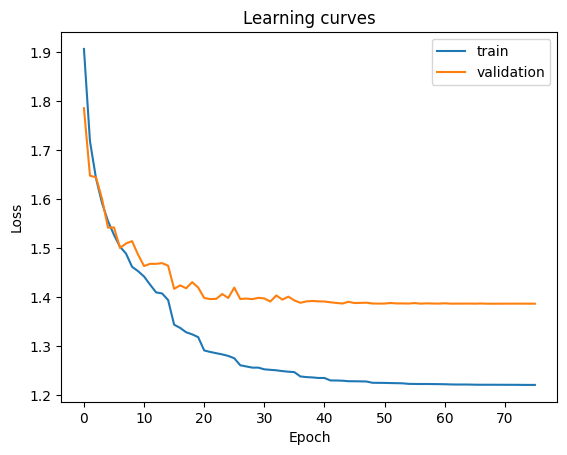

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('Learning curves')

# **THE END**